## 4. Predictive analytics

### 4.1 Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import holidays
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

In [2]:
filepath = 'data/'

In [3]:
trip_data = pd.read_pickle(filepath+'trip_data.pkl')
weather_data = pd.read_pickle(filepath+'weather_data.pkl')
station_data = pd.read_pickle(filepath+'station_data.pkl')
#geo_data = pd.read_pickle(filepath+'geo_data.pkl')

### 4.2 Data Prep for Regression

#### 4.2.1 Feature Engineering

We use the weather data as a base dataframe because it already contains all datetimes. We will build upon that. We suspect that time and weather (tempereature and precip) is correlated with demand. We therefore construct our features around that.

In [4]:
data = weather_data.copy()

We will use the average temperature per hour as a feature and drop min/max temperatures later on.

In [5]:
data['temp'] = (data['max_temp']+data['min_temp'])/2

Now we merge the trip data (aggregated by every hour) to our dataframe.

In [6]:
#aggregate hourly demand from our trip data
demand = trip_data.groupby(pd.Grouper(key='start_time', freq='H')).agg({'duration':'count'})
demand.rename(columns={'duration':'demand'}, inplace=True)
#add hourly demand to our data
data = pd.merge(data, demand, left_on='date_time', right_on=demand.index, how='left')

We add datetime data as features to our data.

In [7]:
# start hour = absolute hour within the a day (0-23h)
data['hour'] = pd.DatetimeIndex(data['date_time']).hour

# weekday = day within a single week (values 0-6, where 0 = monday)
data['weekday'] = pd.DatetimeIndex(data['date_time']).weekday

# number of the month (1-12, where 1 = January)
data['month'] = pd.DatetimeIndex(data['date_time']).month

Because timedata is circular, we transform hour, weekday and month into sin/cos values for higher accuracy in our linear model. ("cyclical feature encoding", see https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca for theory behind that). As our other models need one single value for each feature, we will keep the linear values for them.

In [8]:
def encode_cyclical_data(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return df

In [9]:
data = encode_cyclical_data(data, 'hour', 24)
data = encode_cyclical_data(data, 'weekday', 7)
data = encode_cyclical_data(data, 'month', 12)

We add 'is_weekend' as a feature.

In [10]:
data['is_weekend'] = data['weekday'].apply(lambda x: 0 if x < 5 else 1)

As we already did in the clustering part, we add public holidays in Massachusetts as a feature.

In [11]:
#create dict with holidays
ma_holidays = holidays.country_holidays('US', subdiv='MA')

#add binary variable if date is public holiday
data['is_holiday'] = data['date_time'].apply(lambda x: 1 if x in ma_holidays else 0)

Set categorical features (time & binary data) as category.

In [12]:
def set_category(df, features):
    for f in features:
        df[f] = df[f].astype('category')
    return df

In [13]:
cat_features = ['hour', 'weekday', 'month', 'is_weekend','is_holiday']
data = set_category(data, cat_features)

Drop irrelevant columns.

In [14]:
data.drop(columns=['date_time','max_temp','min_temp'], inplace=True)

### 4.3 Model Building

Our ideas which algorithms to use:
- One algorithm w/ good "explainability" of how features affect the outcome: polynomial regression. drawback: computiationally very expensive and therefore slow.
- Decision Tree Regression for speed
- Gradient Tree Boosting as a boosting method for speed and because it finds its own hyperparameters. A potential drawback might be overfitting.

Our evaluation metrics are R² (how much is the model able to explain) as well as MAE to show absolute deviations of the predicted to the actual values. MAE is advantageous in our use case because it treats positive and negative errors equally, and the result is always non-negative. This gives a better sense of the magnitude of the errors, regardless of their direction and is not as sensitive to outliers. It would be beneficial to add another metric such as MAPE to give better insights into the performance of the models, but we have a substantial amount of outcome variables that equal to zero and therefore creates arbitrarily high values for MAPE.

In [15]:
#check if we can use MAPE as a metric to evaluate our models
len(data.loc[(data['demand']==0)])

136

#### 4.3.1 Train-Test-Split

Now we make a train/test split for cross-validation. We train our models on 70% of the data and evaluate the performance on 30% of the data. While we have timeseries data, we will not use a timeseries split (e.g. by using the function "temporal_train_test_split()" or adding parameter "shuffle=False") because we have seasonality in our data that we cannot capture if we split the last weeks/months into the test set.

In [16]:
#create a list of features for the train test split
features = data.columns.tolist()
features.remove('demand')

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data[features], data['demand'], test_size=0.3, random_state=7)

In [18]:
def drop_cols(df, dropcols):
    """
    Method to drop columns in a dataframe as we do not need all features for all prediction methods.
    Input: df, dropcols (list)
    Returns: df
    """
    df_clean = df.drop(columns=dropcols)
    return df_clean

#### 4.3.2 Regression Algorithm 1: Polynomial Regression

We additionaly use ridge regularization to avoid overfitting. We chose ridge over lasso regularization because we do not have many features. Ridge is also better to suited if there are correlated features. Because our data only consists of date, time and weather data this is most likely the case. For both the polynomial regression and the ridge regression we use a grid search approach to find model hyperparameters (number of polynomials and lambda respectively).

In [19]:
def run_poly_regression(X_train, X_test, y_train, y_test, pmax, lam=0, final=False):
    """
    Method to run polynomial regression and plot the data.
    Input: X_train, y_train, X_test, y_test, pmax (int), lam (float), 
        final (bln): set True to return coefficients of the regression - not intended to work when iterating through polynomials.
    Returns: None
    """
    #remove linear timedata because we use sin/cos values for linear regression
    dropcols = ['hour','weekday','month']
    X_train = drop_cols(X_train, dropcols)
    X_test = drop_cols(X_test, dropcols)
    
    r2_list = []
    mae_train = []
    mae_test = []
    
    #iterate through a range of possible p-values if lambda for ridge regression is not passed
    #if lambda is passed: final model will be built
    if final == False:
        polynomials = [*range(1,pmax)]
    else:
        polynomials = [pmax]
    
    for p in polynomials:    
        # fit the model on the training data
        poly_reg = PolynomialFeatures(degree = p)
        x_poly_train = poly_reg.fit_transform(X_train)
        x_poly_test = poly_reg.fit_transform(X_test)
        
        model = Ridge(alpha=lam, normalize=True, solver='lsqr')
        model.fit(x_poly_train, y_train)

        # evaluate the model on the train data
        train_pred = model.predict(x_poly_train)
        # evaluate the model on the test data
        test_pred = model.predict(x_poly_test)
    
        #calculate R² & MAE for evaluation of train & test performance
        r2_list.append(r2_score(y_test, test_pred))
        mae_train.append(mean_absolute_error(y_train, train_pred))
        mae_test.append(mean_absolute_error(y_test, test_pred))
        
    #plot graph only when we iterate through polynomials
    if final == False:
        # plot the data
        plt.semilogy(polynomials, mae_train, polynomials,mae_test)
        plt.legend(['Training Data', 'Validation Data'])
        plt.xlabel('Polynomial Degree')
        plt.ylabel('Mean absolute error (MAE)')
        plt.show()
    
    #print metrics
    #correct the value that is printed for the polynomial degree for final view
    if final == True:
        p_print = str(pmax)
    else:
        p_print = str(np.argmin(mae_test)+1)
    
    print("Best performance in the test data (metric: MAE test):"
        + "\nPolynominal degree: " + p_print 
        + "\nR²: " + str(round(r2_list[np.argmin(mae_test)],3)) 
        + "\nMAE (train): " + str(round(mae_train[np.argmin(mae_test)],3))  
        + "\nMAE (test): " + str(round(mae_test[np.argmin(mae_test)],3))  
    )
    
    #print coefficients when we have our final hyperparameters
    if final == True:
        print("Features: " + str(X_test.columns)
              +"\nCoefficients: " + str(model.coef_)
              +"\nIntercept: " + str(model.intercept_)
             )
        
    return None

In [20]:
def run_ridge_regression(X_train, X_test, y_train, y_test, p):
    #remove linear timedata because we use sin/cos values for linear regression
    dropcols = ['hour','weekday','month']
    X_train = drop_cols(X_train, dropcols)
    X_test = drop_cols(X_test, dropcols)
    
    poly_reg = PolynomialFeatures(degree = p)
    x_poly_train = poly_reg.fit_transform(X_train)
    x_poly_test = poly_reg.fit_transform(X_test)
    
    
    #(consider that higher ranges for lambda might cause a memory error)
    lam = np.logspace(0, 20, 40)
    
    lam_list = []
    mae_train = []
    mae_test = []

    for l in lam:
        #we set copy_X=False for performance reasons; otherwise we get a memory error.
        model_L2 = Ridge(alpha=l, normalize=True, solver='lsqr', copy_X=False)
        model_L2.fit(x_poly_train, y_train)
        
        # evaluate the model on the train data
        train_pred = model_L2.predict(x_poly_train)
        # evaluate the model on the test data
        test_pred = model_L2.predict(x_poly_test)

        #calculate MAE for evaluation of train & test performance
        lam_list.append(l)
        mae_train.append(mean_absolute_error(y_train, train_pred))
        mae_test.append(mean_absolute_error(y_test, test_pred))
    
    plt.loglog(lam, mae_train, lam, mae_test)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Regularization parameter $\lambda$')
    plt.ylabel('Mean absolute error')
    
    print("Best performance in the test data (metric: MAE test):"
        + "\nLambda: " + str(lam_list[np.argmin(mae_test)+1]) 
        + "\nMAE (train): " + str(round(mae_train[np.argmin(mae_test)],3))  
        + "\nMAE (test): " + str(round(mae_test[np.argmin(mae_test)],3))  
    )

    return None

We limit the number of polynomials to iterate through to a number of 9 (while we have 10 features), as higher numbers get computiationally more and more expensive and cause memory errors. Additionally, overfitting gets less likely.

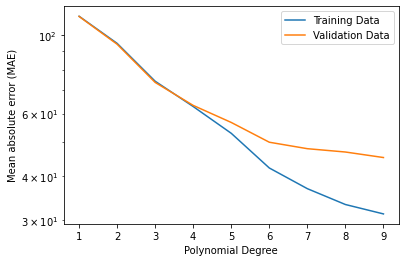

Best performance in the test data (metric: MAE test):
Polynominal degree: 9
R²: 0.9
MAE (train): 31.226
MAE (test): 45.091


In [21]:
run_poly_regression(Xtrain, Xtest, ytrain, ytest, 10, 0)

We decide that 6 polynomials give a great trade-off in performance and to avoid overfitting.

As it is computationally expensive to compute the optimal lambda, we only compute 10 iterations in the logspace.

Best performance in the test data (metric: MAE test):
Lambda: 3.257020655659783
MAE (train): 161.605
MAE (test): 52.457


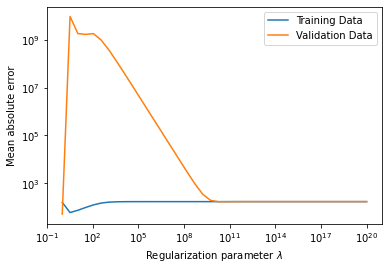

In [22]:
run_ridge_regression(Xtrain, Xtest, ytrain, ytest, 6)

The best trade-off on training and test performance is for lambda=0, i.e. no ridge regularization. We conclude that our polynomial regression benefits more from the polynomials than from the regularization term. 

We run a final regression with our hyperparameters p=9 and lambda=0 to get the intercept and coefficients. This allows us to interpret the relationships of the features on the outcome.

In [23]:
run_poly_regression(Xtrain, Xtest, ytrain, ytest, 6, 0, final=True)

Best performance in the test data (metric: MAE test):
Polynominal degree: 6
R²: 0.895
MAE (train): 42.121
MAE (test): 49.822
Features: Index(['precip', 'temp', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'is_weekend', 'is_holiday'],
      dtype='object')
Coefficients: [ 0.         -2.2405066   0.47817678 ... -0.93239365 -0.93239365
 -0.6285511 ]
Intercept: 159.2794755783374


#### 4.3.3 Regression Algorithm 2: Decision Tree

In [24]:
def run_decision_tree(X_train, X_test, y_train, y_test, d_max):
    """
    Method to run polynomial regression and plot the data.
    Input: X_train, y_train, X_test, y_test, pmax, lam
    Returns: None
    """
    #delete sin/cos columns
    dropcols = ['hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos']
    X_train = drop_cols(X_train, dropcols)
    X_test = drop_cols(X_test, dropcols)
    
    r2_list = []
    mae_train = []
    mae_test = []
    nodes = []
    leaves = []
    depth = []
    
    for d in range(1,d_max):
        # fit regression model
        tree_reg = DecisionTreeRegressor(max_depth=d, criterion="mae")
        tree_reg.fit(X_train, y_train)

        # predict
        train_pred = tree_reg.predict(X_train)
        test_pred = tree_reg.predict(X_test)

        #calculate R² & MAE for evaluation of train & test performance
        r2_list.append(r2_score(y_test, test_pred))
        mae_train.append(mean_absolute_error(y_train, train_pred))
        mae_test.append(mean_absolute_error(y_test, test_pred))
        
        #save attributes for comparison
        nodes.append(tree_reg.tree_.node_count)
        leaves.append(tree_reg.tree_.n_leaves)
        depth.append(d)
    
    # plot the data
    plt.semilogy(range(1,d_max), mae_train, range(1,d_max),mae_test)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Max. Tree Depth')
    plt.ylabel('Mean absolute error (MAE)')
    plt.show()
    print("Best performance in the test data (metric: MAE test):"
        + "\nTree depth: " + str(depth[np.argmin(mae_test)])
        + "\nnumber of nodes: " + str(nodes[np.argmin(mae_test)])
        + "\nnumber of leafs: " + str(leaves[np.argmin(mae_test)])
        + "\nR²: " + str(round(r2_list[np.argmin(mae_test)],3)) 
        + "\nMAE (train): " + str(round(mae_train[np.argmin(mae_test)],3)) 
        + "\nMAE (test): " + str(round(mae_test[np.argmin(mae_test)],3)) 
        )
    return None

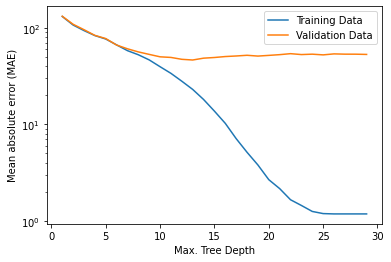

Best performance in the test data (metric: MAE test):
Tree depth: 13
number of nodes: 4387
number of leafs: 2194
R²: 0.858
MAE (train): 23.023
MAE (test): 46.467


In [25]:
run_decision_tree(Xtrain, Xtest, ytrain, ytest, 30)

Decision Tree is obviously much faster than poly regression, however the prediction performance poses a trade-off for speed.

#### 4.3.4 Regression Algorithm 3: Gradient Tree Boosting

In [26]:
def change_dtypes(df):
    column_types = {'precip': float, 'temp': float, 'hour': int, 'weekday': int, 'month': int, 'is_weekend': bool, 'is_holiday': bool}
    df = df.astype(column_types)
    return df

In [27]:
def run_xgb(X_train, X_test, y_train, y_test):
    #delete sin/cos columns
    dropcols = ['hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos']
    X_train = drop_cols(X_train, dropcols)
    X_test = drop_cols(X_test, dropcols)
    
    #as XGBoost does not allow categorical values, we change the dtypes accordingly
    X_train = change_dtypes(X_train)
    X_test = change_dtypes(X_test)

    #run model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, test_pred)
    mae_train = mean_absolute_error(y_train, train_pred)
    mae_test = mean_absolute_error(y_test, test_pred)
    
    print("R²: " + str(r2)
        + "\nMAE (train): " + str(round(mae_train,3)) 
        + "\nMAE (test): " + str(round(mae_test,3))
         )
    return None

In [28]:
run_xgb(Xtrain, Xtest, ytrain, ytest)

R²: 0.9109249045692135
MAE (train): 24.63
MAE (test): 38.272


XGBoost is by far our fastest algorithm and shows the best prediction values on the test set.

### 4.4 Model Evaluation

See write-up for an evaluation.

### 4.5 Outlook

See write-up for an outlook.